# Майнор по Анализу Данных, Группа ИАД-2
## Домашнее задание №3 
## Деревья решений, случайный лес
**Срок сдачи:** 3 июня 2017, 23:59

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (12,6)
plt.rc('font', family='Arial')
# plt.style.use('ggplot')

np.set_printoptions(suppress=True)

In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
GLBL_START_T = time()

# Classify leaf with random forest
Задание основано на Kaggle соревновании [Leaf Classification](https://www.kaggle.com/c/leaf-classification/).

Помните [Iris](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)? Данные, с которыми вам предстоит работать в этом задании концептуально похожи на ирисы.

Дана информация о 990 листьях, каждый из которых был сорван с одного из 99 видов растений.</br> 
Необходимо построить модель, которая могла бы определить, к какому растению относится каждый лист.

## Табличные данные
Загрузите файл `table_data.csv`.

В нем вы можете найти
* id - идентификатор листика
* species - столбец с названием растения (класс)
* margin, shape, texture - некоторые признаки листьев

In [3]:
DATA_DIR = os.path.join(r"data/leaves/")
IMG_DIR = os.path.join(DATA_DIR, 'images')

table_path = os.path.join(DATA_DIR, 'table_data.csv')
table_data = pd.read_csv(table_path, index_col=0)

table_data.head()

species   margin1   margin2   margin3   margin4   margin5  \
id                                                                            
1             Acer_Opalus  0.007812  0.023438  0.023438  0.003906  0.011719   
2   Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625  0.025391   
3    Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812  0.003906   
5         Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859  0.021484   
6      Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766  0.013672   

     margin6   margin7  margin8   margin9    ...      texture55  texture56  \
id                                           ...                             
1   0.009766  0.027344      0.0  0.001953    ...       0.007812   0.000000   
2   0.001953  0.019531      0.0  0.000000    ...       0.000977   0.000000   
3   0.005859  0.068359      0.0  0.000000    ...       0.154300   0.000000   
5   0.019531  0.023438      0.0  0.013672    ...       0.000000   0.000977   
6   0.015625  0.005859      0.0  0.000000    ...       0.096680   0.000000   

    texture57  texture58  texture59  texture60  texture61  texture62  \
id                                                                     
1    0.002930   0.002930   0.035156        0.0        0.0   0.004883   
2    0.000000   0.000977   0.023438        0.0        0.0   0.000977   
3    0.005859   0.000977   0.007812        0.0        0.0   0.000000   
5    0.000000   0.000000   0.020508        0.0        0.0   0.017578   
6    0.021484   0.000000   0.000000        0.0        0.0   0.000000   

    texture63  texture64  
id                        
1    0.000000   0.025391  
2    0.039062   0.022461  
3    0.020508   0.002930  
5    0.000000   0.047852  
6    0.000000   0.031250  

[5 rows x 193 columns]

## Создание контрольного и обучающих множеств (1 балл)
* Задайте `random_seed`, который необходимо будет использовать при **всех** случаях использования генератора случайных чисел.
* С помощью LabelEncoder закодируйте столбец `species` из исходных данных - вы должны получить одномерный numpy массив с метками классов от 0 до 98.
* В переменную `X` запишите значения признаков margin, shape, texture - вы должны получить многомерный numpy массив.

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
encoder = LabelEncoder()
species = table_data.loc[:, 'species']
table_data.loc[:, 'species'] = encoder.fit_transform(table_data.loc[:, 'species'])

table_data.loc[:, 'species'].head()

id
1     3
2    49
3    65
5    94
6    84
Name: species, dtype: int64

Получение массива объект-признак (X) и вектора ответов (y).

In [6]:
X = table_data.iloc[:, 1:].values
y = table_data.loc[:, "species"].values
print(X.shape, y.shape)

(990, 192) (990,)


* Случайным образом разбейте данные на обучающую и контрольную выборку, причем так, чтобы в контрольной выборке содержалось по 2 объекта каждого класса.
* Сохраните индексы объектов обучающего и контрольного множеств в переменные train_idx и test_idx
###### [Это](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) может помочь.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

Функции для проверки числа объектов каждого класса в выборке.

In [8]:
def unique_count(x):
    unique, inverse = np.unique(x, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack((unique, count)).T

def check_more_than(x, n=2):
    return np.all(x[:, 1] >= n)

Разбиение.

In [9]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
# train_idx, test_idx = [(i, j) for i, j in splitter.split(X, y)][0]
for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
print(check_more_than(unique_count(y_test), 2))
print(X_train.shape, X_test.shape)

True
(792, 192) (198, 192)


## Сравнение RF, DT и Bagging'а (2 балла)
На кросс-валидации по обучающей выборке сравните качество и скорость:
1. Обычного дерева решений.
2. Bagging'a над деревьями решений с 10, 50, 100, 200 и 300 деревьями. [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
3. Cлучайного леса с 10, 50, 100, 200 и 300 деревьями. [doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)


* Изобразите полученные результаты на одном графике.
* Используйте `StratifiedKFold` с 4 фолдами для оценки качества.
* Мера качества - `accuracy`.

In [10]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from timeit import timeit

Создание объекта StratifiedKFold с 4 фолдами.

In [11]:
skfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

Задание словаря рассматриваемых моделей и параметров для них.

In [12]:
n_trees = (10, 50, 100, 200, 300)
models_params = {}
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED),
    'Bagging': BaggingClassifier(random_state=RANDOM_SEED)
}
cv_params = {
    'Decision Tree': {},
    'Random Forest': dict(n_estimators=n_trees),
    'Bagging': dict(n_estimators=n_trees)
}

Вспомогательные функции:
* benchmark - оценка качества моделей;
* display_benchmark_result - отображение результатов оценки качества.

Полученные результаты отображены на 3х графиках:
* среднее значение accuracy;
* среднее время обучения;
* среднее время предсказания.

In [13]:
def benchmark(models, params, X, y=None, kf=None) -> list:
    log = []
    for model_type in models:
        cv_grid = GridSearchCV(
            estimator=models[model_type],
            param_grid=params[model_type],
            scoring=make_scorer(accuracy_score), 
            cv=kf
        )
        res_grid = cv_grid.fit(X, y)
        log.append(res_grid.cv_results_)
    return log

def display_benchmark_result(models, cv_logs) -> None:
    if len(models) != 3:
        raise AttributeError
    fig, ax = plt.subplots(1, len(models))
    for i, model_type in enumerate(models):
        fit_t = cv_logs[i]['mean_fit_time']
        score_t = cv_logs[i]['mean_score_time']
        scores = cv_logs[i]['mean_test_score']
        print(f"> {model_type}\nmean times:\n\tfit:\t{fit_t}\n\tscore:\t{score_t}\nscores:\t{scores}")
        if len(scores) == 1:
            _ = ax[0].plot(1, scores, 'o')
            _ = ax[1].plot(1, fit_t, 'o')
            _ = ax[2].plot(1, score_t, 'o')
        else:
            _ = ax[0].plot(n_trees, scores, '.-')
            _ = ax[1].plot(n_trees, fit_t, '.-')
            _ = ax[2].plot(n_trees, score_t, '.-')
    titles = ["mean scores", "mean fit times", "mean score times"]
    for i in range(3):
        _ = ax[i].set_title(titles[i])
        _ = ax[i].legend(models.keys())
        _ = ax[i].set_xlabel("n_estimators")
    _ = ax[0].set_ylabel("accuracy")
    _ = ax[1].set_ylabel("time")
    _ = ax[2].set_ylabel("time")

Обучение моделей.

In [14]:
start_t = time()
cv_logs = benchmark(models, cv_params, X_train, y_train, skfold)
print(f"End for {time() - start_t} s.")

End for 655.1396698951721 s.


Отображение результатов каждой модели.

In [15]:
display_benchmark_result(models, cv_logs)

> Decision Tree
mean times:
	fit:	[ 0.24830014]
	score:	[ 0.00050026]
scores:	[ 0.61363636]
> Random Forest
mean times:
	fit:	[ 0.11520141  0.6164158   1.18891442  2.3321178   3.42180479]
	score:	[ 0.00312775  0.01651025  0.02846986  0.058038    0.08943444]
scores:	[ 0.83712121  0.96590909  0.96969697  0.97474747  0.97853535]
> Bagging
mean times:
	fit:	[  2.15931833  10.68615431  21.36913222  42.36381626  63.7154035 ]
	score:	[ 0.00400299  0.01751179  0.03227144  0.0640443   0.09944046]
scores:	[ 0.80050505  0.91414141  0.93181818  0.94570707  0.94318182]


## Загрузка изображений (1 балла)
В папке `images` лежат 1584 изображения различного размера, названные в соответствии с id из файла `table_data.csv`. <br/>
Необходимо:
1. "Стандартизировать" размер изображений - сделать его одинаковым для всех
2. Отобрать изображения тех листьев, которые представлены в `table_data`

Пункт 1. можно сделать двумя способами:
1. C помощью функции scipy.misc.imresize (неидеальный вариант)
2. Найти максимальные длинну и ширину полотна и перенести исходные картинки в центр (кажется, что так лучше)

**В результате этого задания вы должны получить получить массив изображений IMG_train и IMG_test для обучающей и контрольной выборки.**

In [16]:
from scipy.misc import imresize

Поиск максимальных размеров изображений для выполнения способа 2 по стандартизации изображений.

*Примечание: Максимальные параметры изображений слишком велики для обработки (по крайней мере на 8Гб ОЗУ), поэтому изображения пропорционально уменьшены в несколько раз.*

In [17]:
max_width, max_height = 0, 0

for i in table_data.index:
    img_path = os.path.join(IMG_DIR, f"{i}.jpg")
    img = plt.imread(img_path)
    if img.shape[0] > max_height:
        max_height = img.shape[0]
    if img.shape[1] > max_width:
        max_width = img.shape[1]

width_reshape = 150
height_reshape = int(max_height*(width_reshape/max_width))

print(f"{max_height} ({height_reshape}), {max_width} ({width_reshape})")

1089 (100), 1633 (150)


Считывание изображений в массив. *(Как сделать сразу в `np.array()` не через `np.append()`, поскольку данный способ выкидывает ошибку нехватки памяти?)*

*Примечание: Производится загрузка только изображений, данные о которых присутствуют в таблице.*

In [18]:
JUST_RESIZE = False

X_IMG = []
for i in table_data.index:
    img_path = os.path.join(IMG_DIR, f"{i}.jpg")
    img = plt.imread(img_path)
    height, width = img.shape
    if not JUST_RESIZE:
        h_idx = max_height//2 - height//2
        w_idx = max_width//2 - width//2
        canvas = np.zeros((max_height, max_width))
        canvas[h_idx:h_idx+height, w_idx:w_idx+width] = img
        img = canvas
    img = imresize(img, (height_reshape, width_reshape))
    X_IMG.append(img)
X_IMG = np.array(X_IMG)

Демонстрация центров (средних значений) классов. <br/>
Как можно видеть, центры некоторых классов (например 54, 63) очень размыты из-за наличия повернутых изображений листов, а также сложной формы листов. Вдобавок, изображения листов сильно отличаются размером листов.

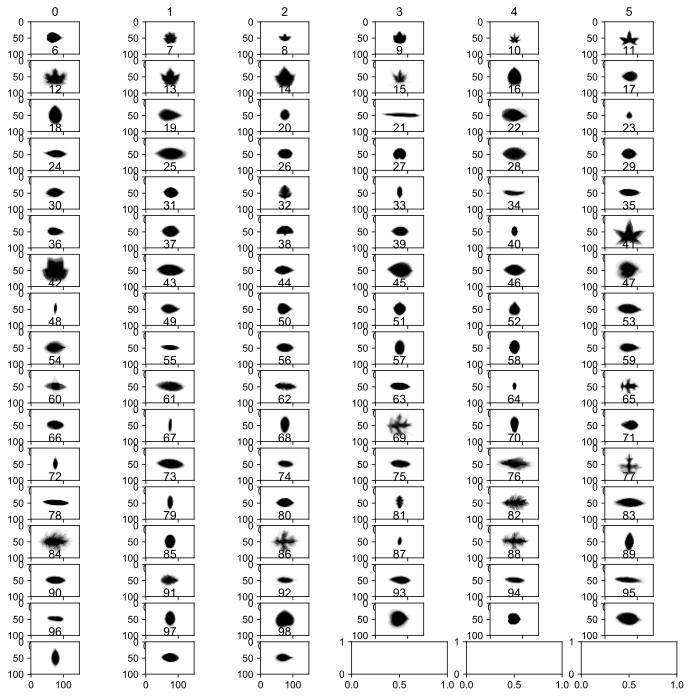

In [19]:
n_plots = 6

classes_idx = np.unique(y)
fig, ax = plt.subplots((len(classes_idx)+n_plots-1)//n_plots, n_plots)
fig.set_size_inches((12,6*(n_plots)//3))

for idx in range((len(classes_idx)+n_plots-1)//n_plots):
    try:
        for i in range(n_plots):
            _ = ax[idx][i].imshow(X_IMG[y == classes_idx[6*idx+i]].mean(axis=0), cmap=plt.cm.Greys)
            _ = ax[idx][i].set_title(6*idx+i)
    except IndexError:
        break

Для разбиения на обучающую и контрольную выборки воспользуемся ранее полученными с помощью `StratifiedShuffleSplit` индексами.

In [20]:
X_IMG_train = X_IMG[train_idx]
X_IMG_test = X_IMG[test_idx]
print(X_IMG_train.shape, X_IMG_test.shape)

(792, 100, 150) (198, 100, 150)


## TSNE (2 балла)

* Переформатируйте IMG_train и IMG_test к виду "матрица объект-признак" (команда reshape)
* На данных в X_train и IMG_train (по отдельности) изобразите результат применения T-SNE со следующими настройками: `n_components=2, perplexity=[5,10,20,30,50], method='exact', n_iter=5000, learning_rate=500`. 
* У вас должно получится 10 `scatter-plot` графиков с точками, расскашенными в цвет своего класса (для наглядности в `plt.scatter` укажите `cmap=plt.cm.Paired`)
* В каком случае (X_train или IMG_train) кластеры выделяются лучше? Как вы думаете, почему?

In [21]:
IMG = X_IMG.reshape((X_IMG.shape[0], -1))
IMG_train = IMG[train_idx]
IMG_test = IMG[test_idx]
print(IMG.shape)

(990, 15000)


In [22]:
from sklearn.manifold import TSNE

Вспомогательная функция для вывода tsne.

In [51]:
def plot_tsne(X, IMG, y, perplexities=(30)):
    fig, ax = plt.subplots(len(perplexities), 2)
    fig.set_size_inches(12, 24)
    tsne = TSNE(n_components=2, method='exact', n_iter=5000, 
                learning_rate=500, random_state=RANDOM_SEED)
    for i, perplexity in enumerate(perplexities):
        _ = tsne.set_params(perplexity=perplexity)
        X_emb = tsne.fit_transform(X)
        IMG_emb = tsne.fit_transform(IMG)
        _ = ax[i][0].scatter(X_emb[:, 0], X_emb[:, 1], s=10, c=y, cmap=plt.cm.Paired, alpha=0.75)
        _ = ax[i][0].set_title(f"perplexity: {perplexity}")
        _ = ax[i][1].scatter(IMG_emb[:, 0], IMG_emb[:, 1], s=10, c=y, cmap=plt.cm.Paired, alpha=0.75)
        _ = ax[i][1].set_title(f"perplexity: {perplexity}")

In [52]:
perplexities = [5, 10, 20, 30, 50]
start_t = time()
plot_tsne(X_train, IMG_train, y_train, perplexities)
print(f"End for {time() - start_t} s.")

End for 115.57079696655273 s.


По полученным графикам довольно сложно судить об отличиях в разделении кластеров (из-за наличия больщого числа классов), однако на графике, построенном по табличным данным кластеры выделяются несколько лучше. Скорее всего, это связано с тем, что табличные данные более иформативны, являются уже некоторой предобработкой данных с изображений и менее зашумленны (64\*3 признаков против 150\*100, при этом большая часть изображения не несет информации о, собственно, листах, а является фоном).

## PCA (1 балл)

* Используйте метод главных компонент, чтобы перейти к пространству меньшей размерности. Подберите количество компонент так, чтобы доля объясненной дисперсии составляла 60%
* Используя результаты МГК на кросс-валидации сравните качество:
    1. Обычного дерева решений 
    2. Bagging'a над деревьями решений с 10, 50, 100, 200 и 300 деревьями
    3. Cлучайного леса с 10, 50, 100, 200 и 300 деревьями
    
#### Hint
Составьте [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) из PCA и предиктивной модели.

In [25]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

Поиск числа компонент с долей объясненной дисперсии равной 60%.

In [26]:
n_X = 2
pca = PCA(n_components=n_X, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)
ratio_X = np.sum(pca.explained_variance_ratio_)

while ratio_X < 0.6:
    n_X += 1
    _ = pca.set_params(n_components=n_X)
    X_pca = pca.fit_transform(X)
    ratio_X = np.sum(pca.explained_variance_ratio_)
print(n_X)

X_train_pca = X_pca[train_idx]
X_test_pca = X_pca[test_idx]

9


Задание моделей с Pipeline и найденным числом компонент.

In [66]:
models_pca = {
    'Decision Tree': Pipeline([
        ("pca", PCA(n_components=n_X, random_state=RANDOM_SEED)),
        ("model", DecisionTreeClassifier(random_state=RANDOM_SEED))
    ]),
    'Random Forest': Pipeline([
        ("pca", PCA(n_components=n_X, random_state=RANDOM_SEED)),
        ("model", RandomForestClassifier(random_state=RANDOM_SEED))
    ]),
    'Bagging': Pipeline([
        ("pca", PCA(n_components=n_X, random_state=RANDOM_SEED)),
        ("model", BaggingClassifier(random_state=RANDOM_SEED))
    ])
}
cv_params_pca = {
    'Decision Tree': {},
    'Random Forest': dict(model__n_estimators=n_trees),
    'Bagging': dict(model__n_estimators=n_trees)
}

Прежде задание выполнялось без использования Pipeline. Для этого данные заранее предобрабатывались с помощью МГК, а затем посылались в уже имеющиеся модели. Были получены идентичные результаты.

In [68]:
start_t = time()
X_pca_logs = benchmark(models_pca, cv_params_pca, X_train, y_train, skfold)
print(f"End for {time() - start_t} s.")
display_benchmark_result(models_pca, X_pca_logs)

End for 55.44633173942566 s.
> Decision Tree
mean times:
	fit:	[ 0.03264624]
	score:	[ 0.00137609]
scores:	[ 0.47979798]
> Random Forest
mean times:
	fit:	[ 0.07279819  0.3000778   0.5206244   1.02195352  1.56693262]
	score:	[ 0.00412828  0.01588523  0.02951986  0.05591631  0.09268588]
scores:	[ 0.58712121  0.67676768  0.68308081  0.70707071  0.7020202 ]
> Bagging
mean times:
	fit:	[ 0.16110724  0.67495626  1.23222107  2.381872    3.54480439]
	score:	[ 0.00387758  0.013008    0.02676725  0.04853189  0.07867688]
scores:	[ 0.59722222  0.6780303   0.69318182  0.6969697   0.68813131]


Для изображений.<br/>
Поиск числа компонент с долей объясненной дисперсии равной 60%.

In [28]:
n_IMG = 2
pca = PCA(n_components=n_IMG, random_state=RANDOM_SEED)
IMG_pca = pca.fit_transform(IMG)
ratio_IMG = np.sum(pca.explained_variance_ratio_)

while ratio_IMG < 0.6:
    n_IMG += 1
    _ = pca.set_params(n_components=n_IMG)
    IMG_pca = pca.fit_transform(IMG)
    ratio_IMG = np.sum(pca.explained_variance_ratio_)
print(n_IMG)

IMG_train_pca = IMG_pca[train_idx]
IMG_test_pca = IMG_pca[test_idx]

6


Задание моделей с Pipeline и найденным числом компонент.

In [71]:
models_pca_IMG = {
    'Decision Tree': Pipeline([
        ("pca", PCA(n_components=n_IMG, random_state=RANDOM_SEED)),
        ("model", DecisionTreeClassifier(random_state=RANDOM_SEED))
    ]),
    'Random Forest': Pipeline([
        ("pca", PCA(n_components=n_IMG, random_state=RANDOM_SEED)),
        ("model", RandomForestClassifier(random_state=RANDOM_SEED))
    ]),
    'Bagging': Pipeline([
        ("pca", PCA(n_components=n_IMG, random_state=RANDOM_SEED)),
        ("model", BaggingClassifier(random_state=RANDOM_SEED))
    ])
}

In [72]:
start_t = time()
IMG_pca_logs = benchmark(models_pca_IMG, cv_params_pca, IMG_train, y_train, skfold)
print(f"End for {time() - start_t} s.")
display_benchmark_result(models_pca_IMG, IMG_pca_logs)

End for 61.22682285308838 s.
> Decision Tree
mean times:
	fit:	[ 0.37625015]
	score:	[ 0.01801181]
scores:	[ 0.40909091]
> Random Forest
mean times:
	fit:	[ 0.43430358  0.62754232  0.81492519  1.19929856  1.61648232]
	score:	[ 0.02176416  0.03252155  0.04390436  0.07344139  0.10682124]
scores:	[ 0.50252525  0.54545455  0.56691919  0.56944444  0.56313131]
> Bagging
mean times:
	fit:	[ 0.45155358  0.76488423  1.15985864  1.9159584   2.67005271]
	score:	[ 0.02013862  0.02964377  0.04140228  0.06304079  0.08955878]
scores:	[ 0.49116162  0.54040404  0.54292929  0.54545455  0.54671717]


При понижении размерности данных модель сильно теряет в качестве предсказаний, однако время обучения сильно сокращается.

# Подбор гиперпараметров модели на табличных данных (2 балла)

С помощью `GridSearchCV` или `RandomizedSearchCV` подберите параметры для случайного леса:
* Используйте `StratifiedKFold` на 4х фолдах
* Мера качества - `accuracy`

Используется ранее созданный StratifiedKFold.<br/>
В выборе участвуют не все параметры, поскольку их перебор требует очень большого количества времени/вычислительных ресурсов.

In [30]:
rf_cv_params = {
    'n_estimators': np.linspace(10, 1000, 20, dtype=int),
#     'n_estimators': np.logspace(1, 3, 20, dtype=int),
#     'criterion': ["gini", "entropy"],
    'max_depth': [None, 20, 25, 30],
#     'max_features': [None, "sqrt", "log2"],
#     'min_samples_split': np.linspace(2, 8, 4, dtype=int),
#     'min_samples_leaf': np.linspace(1, 10, 5, dtype=int),
#     'bootstrap': [True, False],
}

rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

cv_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_cv_params,
    scoring=make_scorer(accuracy_score),
    cv=skfold
)

Подбор параметров на данных с пониженной с помощью МГК размерностью.

In [31]:
start_t = time()
res_X_pca = cv_grid.fit(X_train_pca, y_train)
print(f"End for {time() - start_t} s.")
cross_val_score(res_X_pca.best_estimator_, X_train_pca, y_train, scoring=make_scorer(accuracy_score), cv=skfold)

End for 970.3215630054474 s.


array([ 0.67676768,  0.75757576,  0.67676768,  0.72727273])

Подбор параметров на табличных данных без применения МГК.

In [35]:
start_t = time()
res_X = cv_grid.fit(X_train, y_train)
print(f"End for {time() - start_t} s.")
cross_val_score(res_X.best_estimator_, X_train, y_train, scoring=make_scorer(accuracy_score), cv=skfold)

End for 1865.1970806121826 s.


array([ 0.98484848,  0.98484848,  0.97979798,  0.97979798])

# Проверка на контрольной выборке (1 балл)

* Примените оптимальную модель на контрольной выборке.
* Для нескольких случаев, где была допущена ошибка, выведите истинное изображение листа и одно из изображений листа предсказанного класса.

Проверка на контрольной выборке с использованием МГК.

In [32]:
best_model = res_X_pca.best_estimator_

y_hat_X_pca = best_model.predict(X_test_pca)
best_model_score_pca = accuracy_score(y_test, y_hat_X_pca)

print(best_model_score_pca)

0.767676767677


Проверка на контрольной выборке без МГК.

In [36]:
best_model = res_X.best_estimator_

y_hat_X = best_model.predict(X_test)
best_model_score = accuracy_score(y_test, y_hat_X)

print(best_model_score)

0.944444444444


Как и следовало ожидать, при понижении размерности данных просиходит слиьная потеря в качестве.

Вспомогательная функция для вывода ошибочно классифицированных листьев.<br/>
Дополнительно для каждого неверно классифицированного листа, выводится центр предсказанного класса, один из объектов корректного (действительного) класса и его центр.

In [61]:
def plot_wrong_pred(y_hat, y_test, test_idx, X_IMG, y, n=4):
    wrong_pred_idx = test_idx[y_hat != y_test][:n]
    wrong_pred = y_hat[y_hat != y_test]
    correct_class = y_test[y_hat != y_test]

    fig, ax = plt.subplots(wrong_pred_idx.size, 5)
    fig.set_size_inches((12,6*(wrong_pred_idx.size+6)//7))

    for idx in range(len(wrong_pred_idx)):
        _ = ax[idx][0].imshow(X_IMG[wrong_pred_idx[idx]], cmap=plt.cm.Greys)
        _ = ax[idx][0].set_title("y_hat")
        _ = ax[idx][1].imshow(X_IMG[y == wrong_pred[idx]][0], cmap=plt.cm.Greys)
        _ = ax[idx][1].set_title(f"y_hat class {wrong_pred[idx]}")
        _ = ax[idx][2].imshow(X_IMG[y == wrong_pred[idx]].mean(axis=0), cmap=plt.cm.Greys)
        _ = ax[idx][2].set_title(f"{wrong_pred[idx]} class center")
        _ = ax[idx][3].imshow(X_IMG[y == correct_class[idx]][0], cmap=plt.cm.Greys)
        _ = ax[idx][3].set_title(f"real class {correct_class[idx]}")
        _ = ax[idx][4].imshow(X_IMG[y == correct_class[idx]].mean(axis=0), cmap=plt.cm.Greys)
        _ = ax[idx][4].set_title(f"{correct_class[idx]} class center")

Изобржения некоторых ошибочно классифицированных листов на данных с пониженной размерностью.

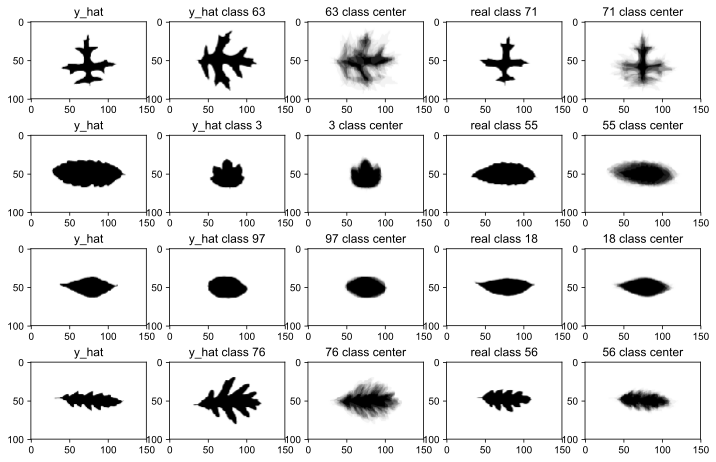

In [63]:
plot_wrong_pred(y_hat_X_pca, y_test, test_idx, X_IMG, y)

Изобржения некоторых ошибочно классифицированных листов на табличных данных.

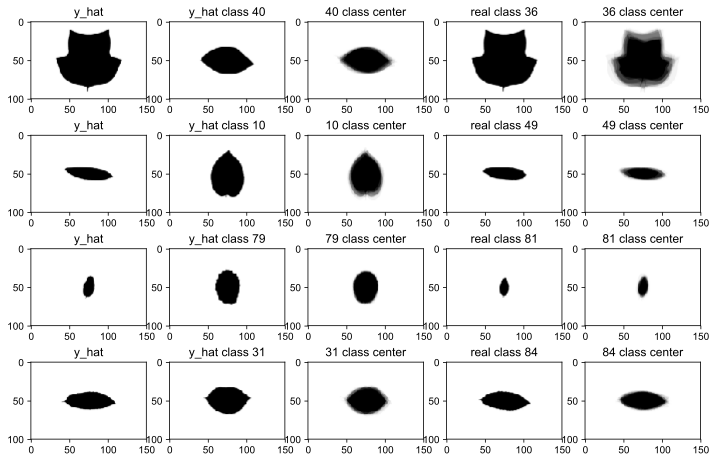

In [64]:
plot_wrong_pred(y_hat_X, y_test, test_idx, X_IMG, y)

# Подбор гиперпараметров модели на объединенных данных (2 балла) **

За это задание можно получить 2 дополнительных балла, но сделать его надо безукоризненно =)

Сейчас мы попробуем использовать данные с изображений и табличные данные, которые затем пойдут на вход случайному лесу. Далее надо будет подобрать оптимальные гиперпараметры случайного леса с помощью кросс-валидации

## Объединяем данные

* Составьте матрицу A_train (A_test) как результаты конкатенации матриц X_train и IMG_train (X_test и IMG_test)

In [38]:
A = np.append(X, IMG, axis=1)
A_train = A[train_idx]
A_test = A[test_idx]

if X.shape[0] != A.shape[0] or X.shape[1] + IMG.shape[1] != A.shape[1]:
    raise ValueError("Wrong ")

print(f"x: {X.shape[0] == A.shape[0]}, y: {X.shape[1] + IMG.shape[1] == A.shape[1]}")
print(A_train.shape, A_test.shape)

x: True, y: True
(792, 15192) (198, 15192)


## Составим  Pipeline
Наш Pipeline условно изображен на рисунке ниже:
![pipline_img](data/leaves/scheme.png)

Из объединенных данных в матрице `А` 
1. Выбираются столбцы, которые относятся к изображению и передаются в `PCA`
2. Исходные табличные данные отделяются от всех остальных, но остаются без изменений
3. Результаты пунктов 1 и 2 объединяются
4. И передаются на вход в случайный лес

В результате в переменную model вы должны записать весь Pipeline из шагов 1-4

#### Hints
* Для того, чтобы выбирать столбцы из матрицы `А` можно использовать `FunctionTransformer` (см. пример ниже)
* Для того, чтобы объединять результаты преобразований можно использовать [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)

In [39]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

In [40]:
def select_col_idx(X, col_idx=(1)):
    return X[:, col_idx]

Создание pipeline, задание параметров для перебора, задание модель GridSearchCV.

In [41]:
pipeline = Pipeline([
    ("union", FeatureUnion([
        ("tbl", FunctionTransformer(select_col_idx, kw_args={'col_idx': range(192)})), 
        ("img", Pipeline([
            ("transform", FunctionTransformer(select_col_idx, kw_args={'col_idx': range(192,15192)})),
            ("pca", PCA(n_components=n_IMG, random_state=RANDOM_SEED))
        ]))
    ])),
    ("model", RandomForestClassifier(random_state=RANDOM_SEED))
])

model_params = {
    'model__n_estimators': rf_cv_params['n_estimators'],
#     'model__criterion': ["gini", "entropy"]
}

cv_grid = GridSearchCV(
    estimator=pipeline,
    param_grid=model_params,
    scoring=make_scorer(accuracy_score),
    cv=skfold
)

Подбор параметров.

In [42]:
start_t = time()
res_grid = cv_grid.fit(A_train, y_train)
print(f"End for {time() - start_t} s.")
cross_val_score(res_grid.best_estimator_, A_train, y_train, scoring=make_scorer(accuracy_score), cv=skfold)

End for 615.4877812862396 s.


array([ 0.99494949,  0.99494949,  0.98484848,  0.98989899])

## Проверка на контрольной выборке

* Примените оптимальную модель на контрольной выборке
* Сравните качество с моделью на табличных данных

In [43]:
final_model = res_grid.best_estimator_

y_hat = final_model.predict(A_test)
final_model_score = accuracy_score(y_test, y_hat)
print(final_model_score)

0.984848484848


Вывод изображений для нескольких случаев, где была допущена ошибка.

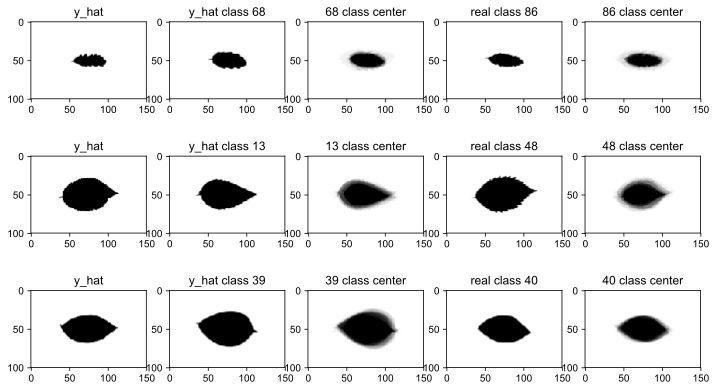

In [65]:
plot_wrong_pred(y_hat, y_test, test_idx, X_IMG, y)

Модель объединенных данные дает лучшие результаты классификации, чем модель с использованием только табличных данных (особенно при понижении размерности).

In [45]:
print(final_model_score - best_model_score_pca)
print(final_model_score - best_model_score)

0.217171717172
0.040404040404


In [46]:
print(f"Общее время выполнения: {time() - GLBL_START_T} c.")

Общее время выполнения: 4470.344203472137 c.
